In [1]:
# Generalized imports
import pandas as pd
import re, datetime
import numpy as np
import warnings, logging
import pickle as pkl
warnings.filterwarnings("ignore")

In [2]:
# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# ML package imports
import sklearn
import keras
import tensorflow
from sklearn.cluster import KMeans

## Utility functions
#### Some of the utility functions that will be used across the project are written in a separate file called "utility_functions.py" for reusability. In this notebook, however, running this cell should be enough to use them inside the project.

Filename: utility_functions.py

In [4]:
from utility_functions import *

## Data cleaning functions

#### Custom functions that help in cleaning of a dataframe have been written inside this file as a class for better readability and reusability.

Filename: data_cleaning.py

In [5]:
from data_cleaning import *

## Reading reuters data from JSON

In [16]:
# Reading the reuters data from a JSON into a Pandas Dataframe
reuters_raw_df = pd.read_json("input_data/xmldata.json")

In [8]:
# Checking the dimensions of reuters data
reuters_raw_df.shape

(48257, 6)

In [17]:
# Checking the first 5 rows of reuters data
reuters_raw_df.head(5)

,headline,text,bip:topics,dc.date.pubished,itemid,XMLfilename
0,RTRS-NAB jumps 2.3 pct on buy-back plan.,\nShares in National Australia Bank Ltd jumped...,"[C15, C152, C17, C171, C18, C181, CCAT]",1997-03-24,464661,464661newsML.xml
1,Care Group Inc Q4 shr loss vs profit.,\n(000's Omitted)\n\t\t\t\t\t YEAR END DECEM...,"[C15, C151, C1511, CCAT]",1997-03-31,476242,476242newsML.xml
2,France urges Israel to stick by Oslo accords.,\nFrance urged Israel on Monday to stick to th...,"[GCAT, GDIP]",1997-03-24,464382,464382newsML.xml
3,Former Mexican official denies taking drug bri...,\nA former Mexican deputy attorney general on ...,"[GCAT, GCRIM]",1997-03-15,445205,445205newsML.xml
4,Krupp says Dortmund furnace won't be closed.,\nKrupp will not close at least part of its Do...,"[C18, C181, C24, CCAT]",1997-03-20,457626,457626newsML.xml


In [19]:
reuters_raw_df.columns

Index(['headline', 'text', 'bip:topics', 'dc.date.pubished', 'itemid',
       'XMLfilename'],
      dtype='object')

## Cleaning the reuters data

In [10]:
# Creating an instance of the custom DataCleaning class
cleaner = DataCleaning()

In [12]:
columns_to_be_cleaned = ["text"]

In [13]:
# Remove the stopwords
reuters_raw_df[["stopwords_removed"]] = reuters_raw_df[columns_to_be_cleaned].applymap(lambda x: DataCleaning.clean_stopwords(x))

In [14]:
# Lemmatize the tokens
reuters_raw_df[["lemmatized_version"]] = reuters_raw_df[["stopwords_removed"]].applymap(lambda x: DataCleaning.lemmatize_tokens(x))

### Reasons for lemmatizing tokens instead of stemming:
- Lemmatization produces meaningful tokens whereas stemming can convert appropriate words into meaningless words.
- Due to stemming, we lose meaning and we run the risk of losing the context as well. This can be harmful when we use deep learning models that try to make sense out of the context. 
- The interpretability of a model is reduced.

In [15]:
# Punctuations are removed
reuters_raw_df[["punctuation_removed"]] = reuters_raw_df[["lemmatized_version"]].applymap(lambda x: DataCleaning.preprocessing(x))

### The numerical data does not seem to add much value and this can greatly affect the dimensions, and hence the numerical data has been dropped.

In [16]:
# Non-alphabets dropped
reuters_raw_df[["non_alpha_removed"]] = reuters_raw_df[["punctuation_removed"]].applymap(lambda x: cleaner.clean_non_alpha(x))

In [28]:
reuters_raw_df[["extra_spaces_removed"]] = reuters_raw_df[["non_alpha_removed"]].applymap(lambda x: cleaner.clean_extra_spaces(x))

In [36]:
reuters_raw_df[["refined_text"]] = reuters_raw_df[["extra_spaces_removed"]].applymap(lambda x: str(x).lower())

In [37]:
reuters_clean_df = pd.DataFrame(columns = ["input", "target"])

In [38]:
reuters_clean_df[["input", "target"]] = reuters_raw_df[["refined_text", "bip:topics"]]

In [39]:
reuters_clean_df["input"][0]

'shares national australia bank ltd jumped cent percent a early monday afternoon trade announcing plan buy back percent million ordinary shares nab cent percent day risen cent earlier trade a however share price dipped back a australian stock exchange announced correct figure million shares earlier announced million share buyback analysts broker said market rallied immediate prospect buyback given prospect buyback already announced november last year nab said november annual result planned buy back million shares equal number share issued dividend reinvestment bonus share share topup plans it said november planned buyback extra million share time raise us million issue exchange tier two capital nab conducted issue socalled exchangeable capital units excaps successfully early month ended raising us billion strong demand nab said announced detail buyback excap issue complete it said million buyback comprised million announced november plus million share offset dividend reinvestment plan 

In [40]:
# Pickling the clean data for future use
pickle(reuters_clean_df, "reuters_clean_df", "clean_data")

In [6]:
# Loading the clean data from the pickled file
reuters_clean_df = unpickle("reuters_clean_df", "clean_data")

In [7]:
reuters_clean_df.shape

(48257, 2)

## EDA - Exploratory Data Analysis
### This is done post cleaning because we did not want to repeat the analysis before and after cleaning. And the cleaning steps that we've done are standard. Thus, the exploratory analysis post cleaning gives us better insight into the data.

### Frequently occuring words in a word cloud

In [9]:
word_cloud_obj = generate_word_cloud(reuters_clean_df, column_name="input")

In [10]:
pickle(word_cloud_obj, "word_cloud_obj", "utility_objects")

In [11]:
word_cloud_obj = unpickle("word_cloud_obj", "utility_objects")

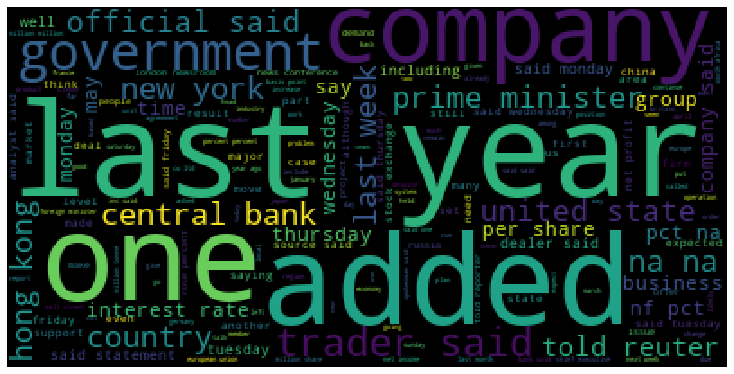

In [19]:
# Visualizing the word cloud
plt.figure(figsize = (10, 10))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(word_cloud_obj)

### Inference
- Clearly, as we can see, the terms like "last year", "added", "company", "hong kong" are the frequently occuring unigrams and bigrams in the corpus after cleaning.

### Frequent topics in a bar graph

In [20]:
# Getting the redundant topics from the corpus to calculate frequency
topics = [each_topic for each_topic_list in reuters_clean_df["target"].tolist() for each_topic in each_topic_list]

In [21]:
topic_df = pd.DataFrame(topics, columns=["topic"])

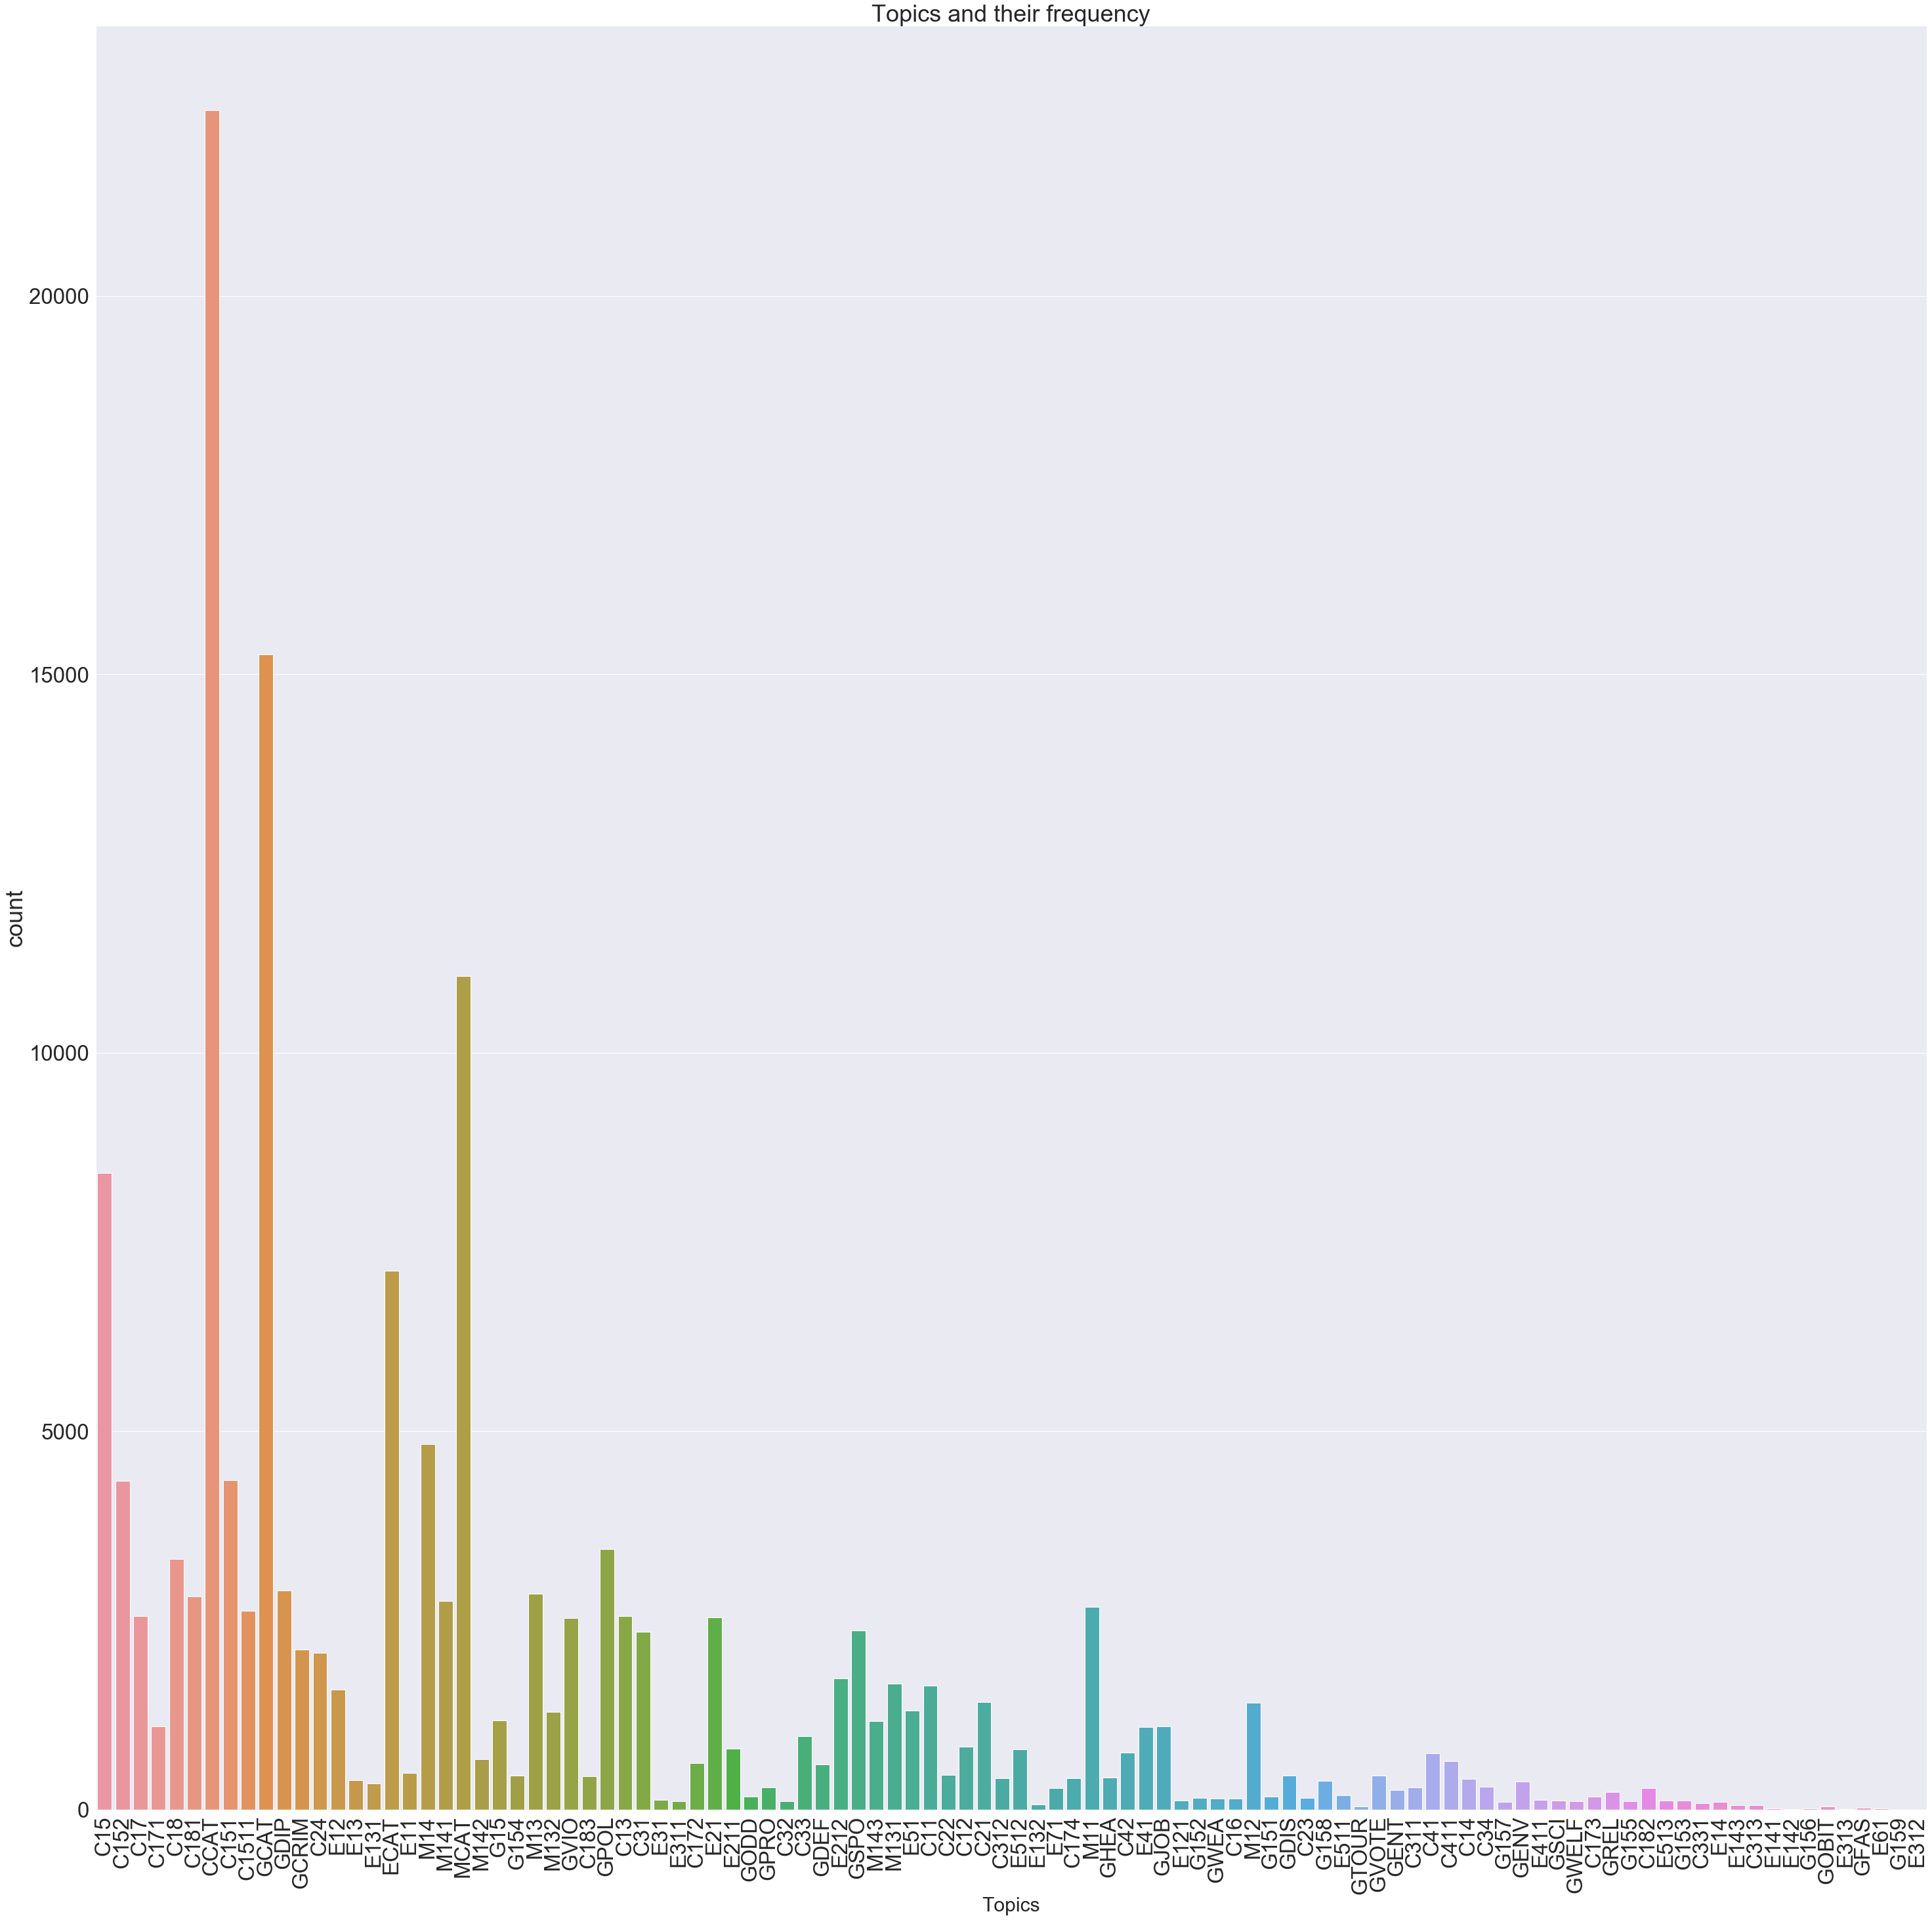

In [22]:
# Visualizing the word cloud
plt.figure(figsize = (50, 50))
sns.set(font_scale=3)
ax = sns.countplot(x="topic", data=topic_df)
ax.set_xlabel("Topics", fontsize=30)
plt.title("Topics and their frequency")
plt.xticks(rotation=90)
plt.show()

### Inference:
- The most frequently occuring topics are CCAT, GCAT.
- This is significant because out of ~48000 records, ~24000 records seem to have CCAT in them. This means that every alternate record belongs to CCAT topic.

### Number of records with single and multiple labels

In [8]:
# Getting the label type: uni-label or multi-label
reuters_clean_df["label_type"] = reuters_clean_df["input"].apply(get_label_type)

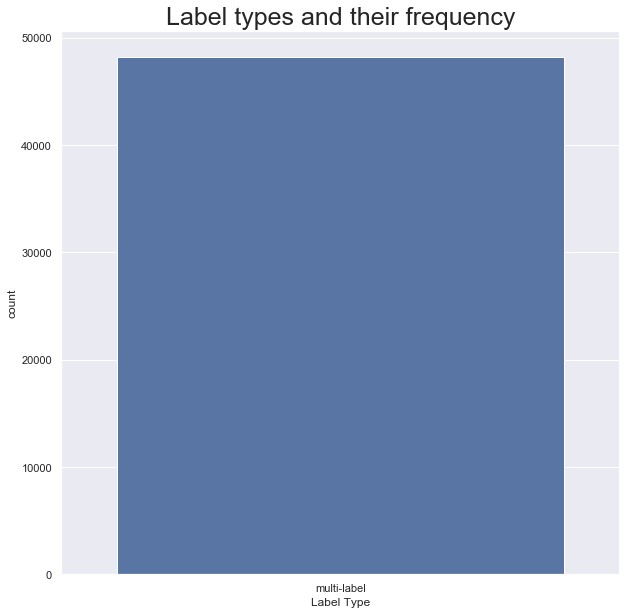

In [39]:
# Visualizing the word cloud
plt.figure(figsize = (10, 10))
sns.set(font_scale=1)
ax = sns.countplot(x="label_type", data=reuters_clean_df)
ax.set_xlabel("Label Type")
plt.title("Label types and their frequency", fontsize=25)
plt.show()

### Inference:
- The corpus given to us does not have uni-label records. 
- This analysis was done to hold the records with uni-labels separately, if there were any. Then, we could have created a simple classifier that performs multi-class classification.
- Now, it is clear from this analysis that this is a multi-label classification problem.

### A simple sentiment analysis to understand the corpus a little better!

In [10]:
# Getting the polarity score of input text
reuters_clean_df["polarity_score"] = reuters_clean_df["input"].apply(get_polarity)

In [11]:
# Getting the sentiment of the input text
reuters_clean_df["sentiment"] = reuters_clean_df["polarity_score"].apply(lambda obj: "positive" if obj>0 else "negative")

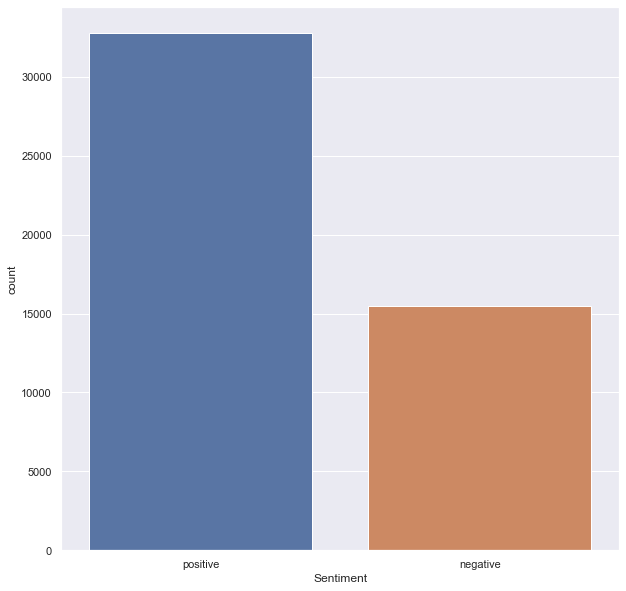

In [40]:
# Visualizing the word cloud
plt.figure(figsize = (10, 10))
sns.set(font_scale=1)
ax = sns.countplot(x="sentiment", data=reuters_clean_df)
ax.set_xlabel("Sentiment")
plt.show()

### Inference:
- The number of records that carry a positive sentiment is ~32000 whereas the ones with a negative sentiment is ~16000.
- This analysis could have helped with a deeper understanding of the corpus and could be used to tune the model to predict the labels.
- However, there is not enough domain knowledge with us to use this as a part of our solution as of now and has been done only for exploratory purposes.

### Words that makes up the positive corpus

In [24]:
positive_df = reuters_clean_df[reuters_clean_df["sentiment"]=="positive"].reset_index().drop("index", axis=1)

In [26]:
positive_word_cloud_obj = generate_word_cloud(positive_df, column_name="input")

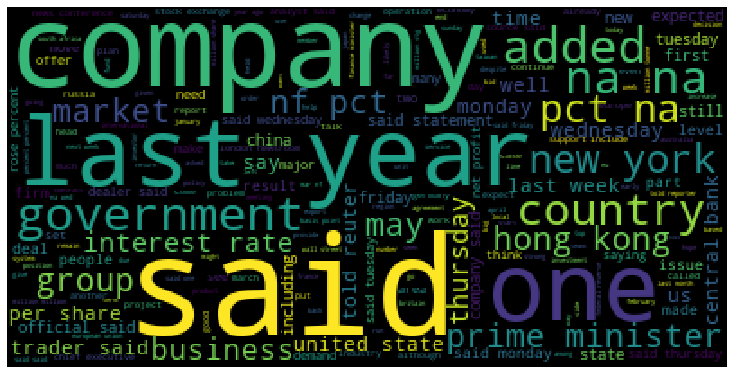

In [27]:
# Visualizing the word cloud
plt.figure(figsize = (10, 10))
plt.axis### Word cloud that makes up the positive corpus("off")
plt.tight_layout(pad=0)
plt.imshow(positive_word_cloud_obj)

### Words that makes up the negative corpus

In [31]:
negative_df = reuters_clean_df[reuters_clean_df["sentiment"]=="negative"].reset_index().drop("index", axis=1)

In [32]:
negative_word_cloud_obj = generate_word_cloud(negative_df, column_name="input")

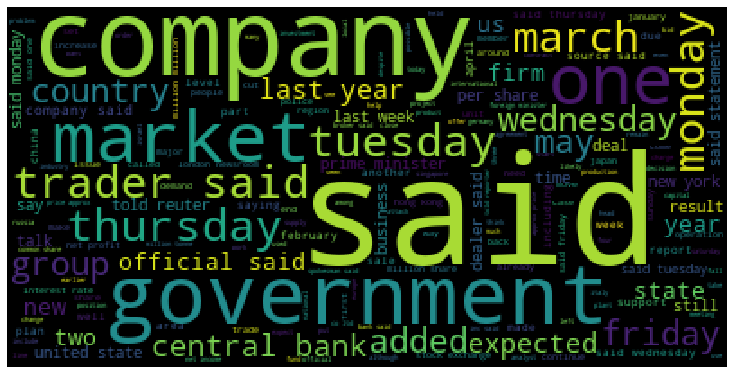

In [33]:
# Visualizing the word cloud
plt.figure(figsize = (10, 10))
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(negative_word_cloud_obj)

In [34]:
pickle(reuters_clean_df, "reuters_clean_eda_df", "clean_data")

In [6]:
reuters_clean_df = unpickle("reuters_clean_eda_df", "clean_data")

## Feature Extraction

### Firstly, a bag of words model is created from the cleaned dataframe. Following this, a TF-IDF vectorizer is used.
### TF-IDF is a technique that gives a statistical measure of how important a term is to the corpus. While computing the TF, each term is given equal importance whereas in the IDF computation, the rare ones across the corpus are given more importance.
### https://www.cs.toronto.edu/~hinton/science.pdf -> 2000 features

In [8]:
%%time
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=2000)
tf_idf_matrix = tf_idf_vectorizer.fit_transform(reuters_clean_df['input'])
print(f"The feature names are:\n {tf_idf_vectorizer.get_feature_names()}")

# Save the tf-idf matrix to a file
pickle(tf_idf_matrix, "tf_idf_2000_features", "tf_idf_models")

The feature names are:
 ['aa', 'aaa', 'ability', 'able', 'about', 'abroad', 'accept', 'accepted', 'access', 'accident', 'accord', 'according', 'account', 'accounting', 'accuracy', 'accused', 'achieve', 'acquire', 'acquired', 'acquisition', 'across', 'act', 'action', 'active', 'activity', 'actual', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'administration', 'administrative', 'advance', 'advantage', 'advertising', 'affair', 'affairs', 'affect', 'affected', 'africa', 'african', 'after', 'afternoon', 'ag', 'again', 'age', 'agency', 'agenda', 'agent', 'ago', 'agree', 'agreed', 'agreement', 'agricultural', 'agriculture', 'ahead', 'aid', 'aim', 'aimed', 'air', 'aircraft', 'airline', 'airlines', 'airport', 'alan', 'albania', 'albanian', 'albanians', 'all', 'allegation', 'alleged', 'alliance', 'allow', 'allowed', 'allowing', 'ally', 'almost', 'along', 'already', 'also', 'alternative', 'although', 'aluminium', 'always', 'am', 'ambassador', 'america', 'american', 'americans',

CPU times: user 8.47 s, sys: 207 ms, total: 8.68 s
Wall time: 9.37 s


## Clustering using KMeans

In [23]:
def run_kmeans(k, tf_idf_matrix):
    kmeans = KMeans(init='k-means++', n_clusters=k, verbose=True, n_init=1).fit(tf_idf_matrix)
    kmeans.labels_

### Running Kmeans for k=3,4,5..10

### The reason why values revolving k=4 are selected is because according to Geoffrey Hinton's supporting material for the research paper states that the reuters corpus fundamentally consists of 4 topics (4 clusters). However, for technical showcasing, we will also test out few other values of k. Generally, in kmeans, whenever the k value is unknown, one of the best way to find it would be according to the use case.

http://www.cs.toronto.edu/~hinton/absps/science_som.pdf \n
http://www.cs.toronto.edu/~hinton/science.pdf

In [ ]:
#RUN THE BELOW 2 CELLS ALONE

In [ ]:
tf_idf_matrix = unpickle("tf_idf_2000_features", "tf_idf_models")

In [ ]:
kvalues = range(7, 11)
kmeans_meta = {}
for k in kvalues:
    kmeans = run_kmeans(k, tf_idf_matrix)
    kmeans_meta[f"kmeans_{k}"] = kmeans
    pickle(kmeans, f"kmeans_{k}_rev", "k_means_models")

## For K = 3

In [13]:
%%time
kmeans_3 = KMeans(init='k-means++', n_clusters=3, verbose=True).fit(tf_idf_matrix)
kmeans_3.labels_

# Save model to file
pickle(kmeans_3, "kmeans_3_rev", "k_means_models")

Initialization complete
Iteration  0, inertia 88366.704
Iteration  1, inertia 45428.224
Iteration  2, inertia 45273.457
Iteration  3, inertia 45250.450
Iteration  4, inertia 45244.641
Iteration  5, inertia 45242.574
Iteration  6, inertia 45241.024
Iteration  7, inertia 45239.281
Iteration  8, inertia 45235.718
Iteration  9, inertia 45231.482
Iteration 10, inertia 45228.315
Iteration 11, inertia 45225.024
Iteration 12, inertia 45215.099
Iteration 13, inertia 45202.800
Iteration 14, inertia 45192.449
Iteration 15, inertia 45188.014
Iteration 16, inertia 45183.882
Iteration 17, inertia 45180.814
Iteration 18, inertia 45178.605
Iteration 19, inertia 45177.249
Iteration 20, inertia 45176.600
Iteration 21, inertia 45176.313
Iteration 22, inertia 45176.125
Iteration 23, inertia 45176.021
Iteration 24, inertia 45175.952
Iteration 25, inertia 45175.882
Iteration 26, inertia 45175.797
Iteration 27, inertia 45175.714
Iteration 28, inertia 45175.536
Iteration 29, inertia 45175.357
Iteration 30, in

Iteration 22, inertia 45170.964
Iteration 23, inertia 45170.108
Iteration 24, inertia 45169.666
Iteration 25, inertia 45169.424
Iteration 26, inertia 45169.294
Iteration 27, inertia 45169.237
Iteration 28, inertia 45169.207
Iteration 29, inertia 45169.197
Iteration 30, inertia 45169.192
Iteration 31, inertia 45169.189
Iteration 32, inertia 45169.187
Iteration 33, inertia 45169.185
Converged at iteration 33: center shift 1.858852e-08 within tolerance 4.777021e-08
Initialization complete
Iteration  0, inertia 87984.760
Iteration  1, inertia 45539.435
Iteration  2, inertia 45241.981
Iteration  3, inertia 45187.197
Iteration  4, inertia 45174.941
Iteration  5, inertia 45171.253
Iteration  6, inertia 45170.169
Iteration  7, inertia 45168.687
Iteration  8, inertia 45161.769
Iteration  9, inertia 45157.757
Iteration 10, inertia 45157.598
Iteration 11, inertia 45157.583
Iteration 12, inertia 45157.577
Iteration 13, inertia 45157.574
Iteration 14, inertia 45157.573
Converged at iteration 14: ce

Iteration 28, inertia 45174.212
Iteration 29, inertia 45174.165
Iteration 30, inertia 45174.072
Iteration 31, inertia 45173.975
Iteration 32, inertia 45173.898
Iteration 33, inertia 45173.838
Iteration 34, inertia 45173.727
Iteration 35, inertia 45173.567
Iteration 36, inertia 45173.462
Iteration 37, inertia 45173.373
Iteration 38, inertia 45173.304
Iteration 39, inertia 45173.248
Iteration 40, inertia 45173.209
Iteration 41, inertia 45173.174
Iteration 42, inertia 45173.151
Iteration 43, inertia 45173.126
Iteration 44, inertia 45173.104
Iteration 45, inertia 45173.069
Iteration 46, inertia 45173.029
Iteration 47, inertia 45172.450
Iteration 48, inertia 45167.566
Iteration 49, inertia 45164.626
Iteration 50, inertia 45161.521
Iteration 51, inertia 45161.418
Iteration 52, inertia 45161.365
Iteration 53, inertia 45161.302
Iteration 54, inertia 45161.164
Iteration 55, inertia 45160.970
Iteration 56, inertia 45160.867
Iteration 57, inertia 45160.812
Iteration 58, inertia 45160.780
Iteratio

### We don't see much change in the cost function across multiple initializations, so making n_init=3

## For K = 4

In [14]:
%%time
kmeans_4 = KMeans(init='k-means++', n_clusters=4, n_init=3, verbose=True).fit(tf_idf_matrix)
kmeans_4.labels_

# Save model to file
pickle(kmeans_4, "kmeans_4_rev", "k_means_models")

Initialization complete
Iteration  0, inertia 87453.881
Iteration  1, inertia 45332.169
Iteration  2, inertia 45105.612
Iteration  3, inertia 45069.395
Iteration  4, inertia 45047.485
Iteration  5, inertia 44997.751
Iteration  6, inertia 44961.990
Iteration  7, inertia 44927.344
Iteration  8, inertia 44890.288
Iteration  9, inertia 44867.863
Iteration 10, inertia 44855.024
Iteration 11, inertia 44847.000
Iteration 12, inertia 44842.377
Iteration 13, inertia 44839.863
Iteration 14, inertia 44838.785
Iteration 15, inertia 44838.385
Iteration 16, inertia 44838.146
Iteration 17, inertia 44838.007
Iteration 18, inertia 44837.949
Iteration 19, inertia 44837.904
Iteration 20, inertia 44837.877
Iteration 21, inertia 44837.858
Iteration 22, inertia 44837.843
Iteration 23, inertia 44837.831
Iteration 24, inertia 44837.821
Iteration 25, inertia 44837.814
Iteration 26, inertia 44837.807
Iteration 27, inertia 44837.800
Iteration 28, inertia 44837.798
Converged at iteration 28: center shift 2.893992

## For K = 5

In [15]:
%%time
kmeans_5 = KMeans(init='k-means++', n_clusters=5, n_init=3, verbose=True).fit(tf_idf_matrix)
kmeans_5.labels_

# Save model to file
pickle(kmeans_5, "kmeans_5_rev", "k_means_models")

Initialization complete
Iteration  0, inertia 84957.835
Iteration  1, inertia 45086.465
Iteration  2, inertia 44851.397
Iteration  3, inertia 44778.368
Iteration  4, inertia 44748.287
Iteration  5, inertia 44725.974
Iteration  6, inertia 44707.266
Iteration  7, inertia 44696.018
Iteration  8, inertia 44686.556
Iteration  9, inertia 44677.696
Iteration 10, inertia 44672.338
Iteration 11, inertia 44669.145
Iteration 12, inertia 44666.937
Iteration 13, inertia 44665.088
Iteration 14, inertia 44663.558
Iteration 15, inertia 44662.315
Iteration 16, inertia 44661.417
Iteration 17, inertia 44660.858
Iteration 18, inertia 44660.462
Iteration 19, inertia 44660.273
Iteration 20, inertia 44660.165
Iteration 21, inertia 44660.101
Iteration 22, inertia 44660.060
Iteration 23, inertia 44660.042
Iteration 24, inertia 44660.028
Iteration 25, inertia 44660.020
Iteration 26, inertia 44660.015
Iteration 27, inertia 44660.012
Iteration 28, inertia 44660.011
Iteration 29, inertia 44660.009
Iteration 30, in

## For K = 6

In [16]:
%%time
kmeans_6 = KMeans(init='k-means++', n_clusters=6, n_init=3, verbose=True).fit(tf_idf_matrix)
kmeans_6.labels_

# Save model to file
pickle(kmeans_6, "kmeans_6_rev", "k_means_models")

Initialization complete
Iteration  0, inertia 87325.551
Iteration  1, inertia 45307.442
Iteration  2, inertia 44892.408
Iteration  3, inertia 44699.757
Iteration  4, inertia 44509.031
Iteration  5, inertia 44429.515
Iteration  6, inertia 44408.179
Iteration  7, inertia 44404.760
Iteration  8, inertia 44403.285
Iteration  9, inertia 44402.787
Iteration 10, inertia 44402.586
Iteration 11, inertia 44402.436
Iteration 12, inertia 44402.337
Iteration 13, inertia 44402.232
Iteration 14, inertia 44402.057
Iteration 15, inertia 44401.937
Iteration 16, inertia 44401.751
Iteration 17, inertia 44401.253
Iteration 18, inertia 44399.833
Iteration 19, inertia 44398.904
Iteration 20, inertia 44398.744
Iteration 21, inertia 44398.675
Iteration 22, inertia 44398.525
Iteration 23, inertia 44398.343
Iteration 24, inertia 44398.257
Iteration 25, inertia 44398.248
Iteration 26, inertia 44398.207
Iteration 27, inertia 44398.198
Iteration 28, inertia 44398.192
Iteration 29, inertia 44398.190
Iteration 30, in

In [17]:
kmeans_6.inertia_

44398.188780319026

In [18]:
kmeans_5.inertia_

44594.24649493311

In [19]:
kmeans_4.inertia_

44837.79626074191

In [20]:
kmeans_3.inertia_

45157.56883692098